# <a id="1">Introduction</a>  


## Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from **April 2005** to **September 2005**. 

## Content

There are 25 variables:

* **ID**: ID of each client
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* **PAY_2**: Repayment status in August, 2005 (scale same as above)
* **PAY_3**: Repayment status in July, 2005 (scale same as above)
* **PAY_4**: Repayment status in June, 2005 (scale same as above)
* **PAY_5**: Repayment status in May, 2005 (scale same as above)
* **PAY_6**: Repayment status in April, 2005 (scale same as above)
* **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)
* **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)
* **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)
* **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)
* **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)
* **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)
* **PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)
* **PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)
* **PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)
* **PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)
* **PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)
* **PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)
* **default.payment.next.month**: Default payment (1=yes, 0=no)



# <a id="2">Load packages</a>

## Load packages

In [223]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import torch

import os

pd.set_option('display.max_columns', 100)

## Set parameters

Here we set few parameters for the analysis and models.

In [224]:
#VALIDATION
VALID_SIZE = 0.35 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation
RANDOM_STATE = 40
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

PATH="data"

print(os.listdir(PATH))

['UCI_Credit_Card.csv']


# <a id="3">Read the data</a>

In [225]:
data_df = pd.read_csv(PATH+"/UCI_Credit_Card.csv")
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# <a id="4">Check the data</a>

In [226]:
print("Default Credit Card Clients data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Default Credit Card Clients data -  rows: 30000  columns: 25


## <a id="41">Glimpse the data</a>

We start by looking to the data features (first 5 rows).

In [227]:
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Let's look into more details to the data.

In [228]:
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


There are 30,000 distinct credit card clients.  

The average value for the amount of credit card limit is 167,484. The standard deviation is unusually large, max value being 1M.

Education level is mostly graduate school and university.

Most of the clients are either marrined or single (less frequent the other status).

Average age is 35.5 years, with a standard deviation of 9.2.

As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).


## <a id="42">Check missing data</a>  

Let's check if there is any missing data.

In [229]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,default.payment.next.month,PAY_6,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,BILL_AMT1,PAY_AMT6,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,ID
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

# <a id="5">Data exploration</a>

## Amount of credit limit 

In [230]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [231]:
def draw_imbalance(df):
    temp = df["default.payment.next.month"].value_counts()
    df = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
    plt.figure(figsize = (6,6))
    plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
    sns.set_color_codes("pastel")
    sns.barplot(x = 'default.payment.next.month', y="values", data=df)
    locs, labels = plt.xticks()
    plt.show()

In [232]:
def draw_credit_limit(df):

    plt.figure(figsize = (14,6))
    plt.title('Amount of credit limit - Density Plot')
    sns.set_color_codes("pastel")
    sns.distplot(df['LIMIT_BAL'],kde=True,bins=200, color="blue")
    plt.show()

## Amount of credit limit grouped by default payment next month

Let's visualize the density plot for amount of credit limit (LIMIT_BAL), grouped by default payment next month.

In [233]:
def draw_credit_next_payment(df):
    class_0 = df.loc[df['default.payment.next.month'] == 0]["LIMIT_BAL"]
    class_1 = df.loc[df['default.payment.next.month'] == 1]["LIMIT_BAL"]
    plt.figure(figsize = (14,6))
    plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
    sns.set_color_codes("pastel")
    sns.distplot(class_1,kde=True,bins=200, color="red")
    sns.distplot(class_0,kde=True,bins=200, color="green")
    plt.show()

Most of defaults are for credit limits 0-100,000 (and density for this interval is larger for defaults than for non-defaults). Larger defaults number are for the amounts of **50,000**, **20,000** and **30,000**.

## Credit limit vs. sex

Let's check the credit limit distribution vs. sex. For the sex, 1 stands for male and 2 for female.

In [234]:
def draw_credit_limit_gender(df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=df, palette="PRGn",showfliers=True)
    s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=df, palette="PRGn",showfliers=False)
    plt.show();

In [235]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data_df, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

In [236]:
def eda_analysis(df):
    
    bills = data_df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
    draw_histograms(bills, bills.columns, 2, 3, 20)
    
    pay = data_df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
    draw_histograms(pay, pay.columns, 2, 3, 20)
    
    draw_credit_limit(df)
    
    draw_credit_limit_gender(df)
    
    boxplot_variation('MARRIAGE','AGE', 'SEX',8)
    
    boxplot_variation('MARRIAGE','LIMIT_BAL', 'EDUCATION',12)
    
    draw_imbalance(df)

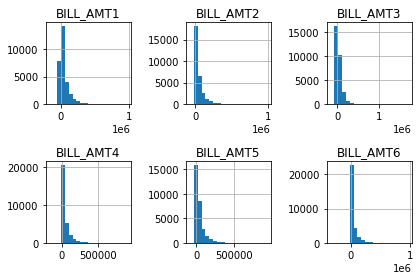

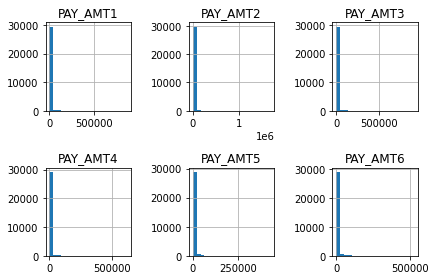

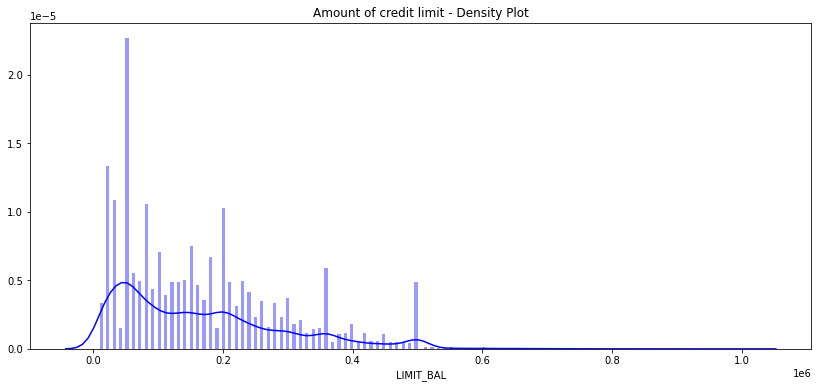

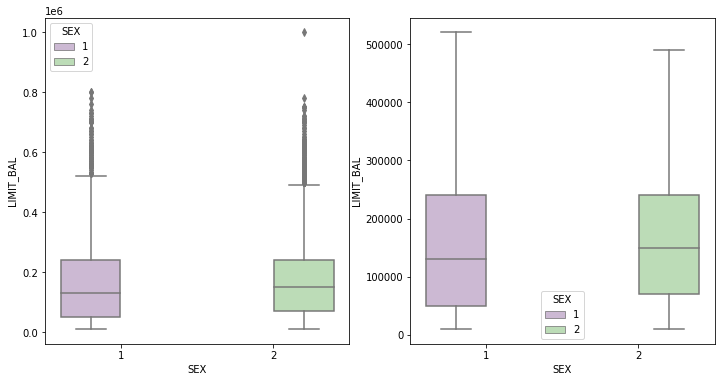

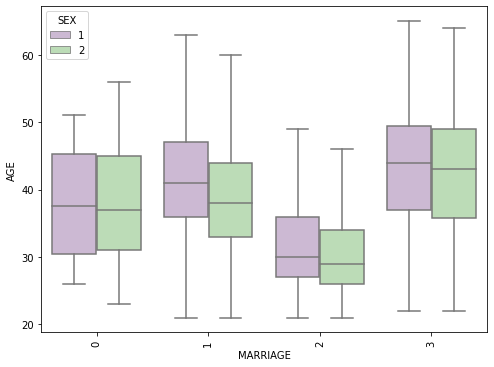

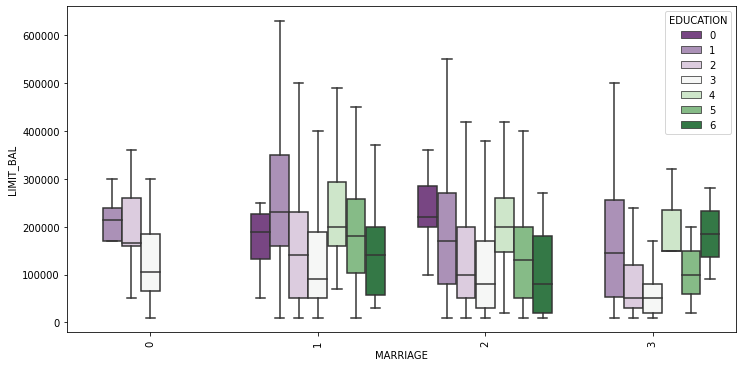

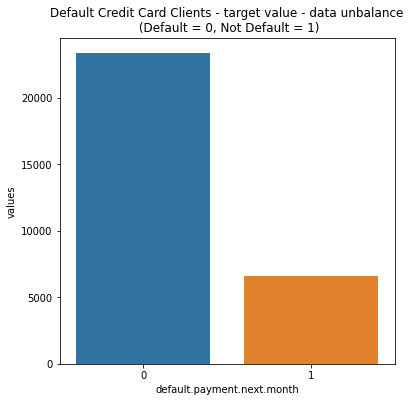

In [237]:
eda_analysis(data_df)

A number of **6,636** out of **30,000** (or **22%**) of clients will default next month. The data has not a large unbalance with respect of the target value (default.payment.next.month).

# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [238]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

### Split data in train and validation set

Let's define train and validation sets.

In [239]:
train_df, val_df = train_test_split(data_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

We also make copies of the train_df and val_df for later usage.

In [240]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

## <a id="64">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [302]:
def create_xgb_model(train_df, val_df, predictors, target):


    # Prepare the train and valid datasets
    dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
    dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

    #What to monitor (in this case, **train** and **valid**)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    # Set xgboost parameters
    params = {}
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.039
    params['silent'] = True
    params['max_depth'] = 2
    # params['subsample'] = 0.8
    # params['colsample_bytree'] = 0.9
    params['eval_metric'] = 'auc'
    params['random_state'] = RANDOM_STATE
    
    
    model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)
    
    fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
    xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
    plt.show()
    
    return model
    

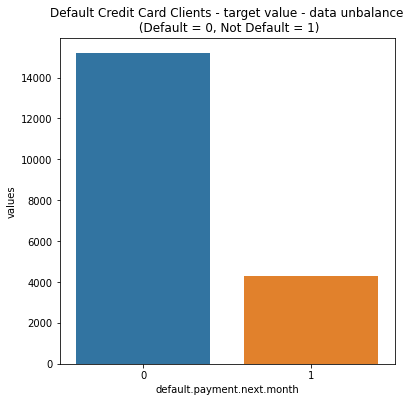

In [394]:
draw_imbalance(train_df)

### Train the model without data changes

Let's train the model. 

[0]	train-auc:0.68913	valid-auc:0.70075
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.76745	valid-auc:0.77209
[100]	train-auc:0.77516	valid-auc:0.77921
[150]	train-auc:0.78092	valid-auc:0.78301
[200]	train-auc:0.78468	valid-auc:0.78514
[250]	train-auc:0.78742	valid-auc:0.78627
[300]	train-auc:0.79008	valid-auc:0.78711
[350]	train-auc:0.79228	valid-auc:0.78755
[400]	train-auc:0.79435	valid-auc:0.78783
[450]	train-auc:0.79614	valid-auc:0.78815
[500]	train-auc:0.79805	valid-auc:0.78812
Stopping. Best iteration:
[478]	train-auc:0.79730	valid-auc:0.78828



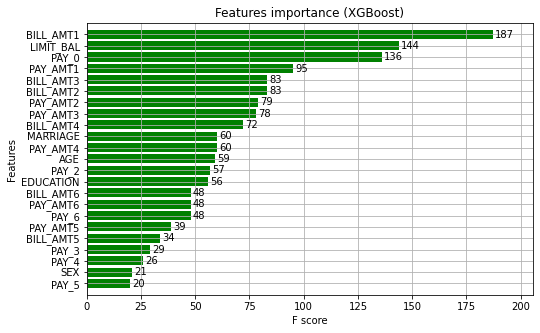

In [242]:
create_xgb_model(train_df, val_df, predictors, target)

The best validation score (ROC-AUC) was **0.78**, for round **453**.

### Plot variable importance

In [243]:
from imblearn.over_sampling import SMOTE

In [244]:
print(len(train_df[target].values))
print(train_df[target].values.sum())

19500
4308


In [245]:
sm = SMOTE(random_state=589)
train_SMOTE, y_SMOTE = sm.fit_sample(train_df[predictors], train_df[target].values)
print(len(y_SMOTE))
print(y_SMOTE.sum())

30384
15192


In [246]:
train_SMOTE[target] = y_SMOTE

In [247]:
train_SMOTE.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,100000.0,1,3,2,47,0,0,0,0,0,-2,94667.0,97088.0,99520.0,102650.0,0.0,0.0,4000.0,4000.0,5000.0,0.0,0.0,0.0,0
1,150000.0,2,3,1,45,0,0,0,0,0,0,59885.0,59054.0,60254.0,59604.0,60707.0,61988.0,2200.0,2200.0,2300.0,2213.0,2300.0,2245.0,0
2,300000.0,2,3,1,34,0,0,0,0,0,0,280823.0,275303.0,271952.0,193403.0,187562.0,191069.0,11000.0,12000.0,7200.0,6500.0,6173.0,5500.0,1
3,240000.0,1,2,1,30,0,0,0,0,0,0,227675.0,181461.0,186160.0,191355.0,192406.0,190086.0,10003.0,10009.0,10014.0,8500.0,10000.0,8000.0,0
4,160000.0,1,3,1,61,-1,-1,-1,-1,0,-1,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,780.0,0.0,390.0,390.0,0


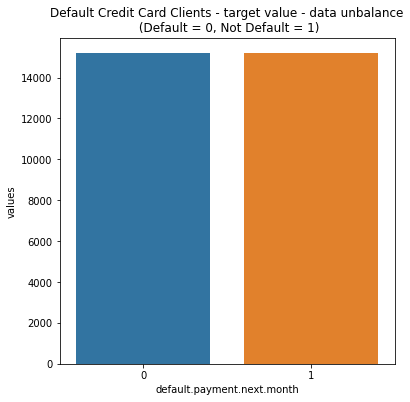

In [393]:
draw_imbalance(train_SMOTE)

[0]	train-auc:0.68817	valid-auc:0.70719
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.80856	valid-auc:0.75104
[100]	train-auc:0.82337	valid-auc:0.75511
[150]	train-auc:0.83062	valid-auc:0.75599
[200]	train-auc:0.83663	valid-auc:0.75624
[250]	train-auc:0.84101	valid-auc:0.75618
Stopping. Best iteration:
[217]	train-auc:0.83838	valid-auc:0.75670



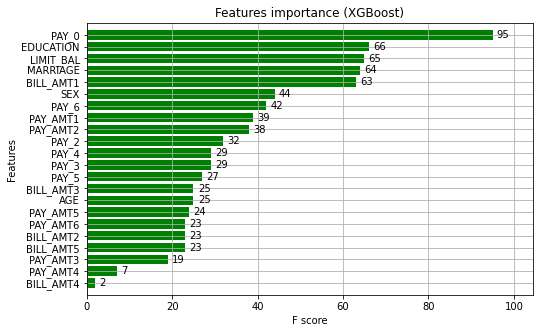

In [248]:
create_xgb_model(train_SMOTE, val_df, predictors, target)

In [249]:
# CTGAN - AI model

In [250]:
ctgan_df = train_df.copy()

In [251]:
ctgan_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
29891,29892,100000.0,1,3,2,47,0,0,0,0,0,-2,94667.0,97088.0,99520.0,102650.0,0.0,0.0,4000.0,4000.0,5000.0,0.0,0.0,0.0,0
11659,11660,150000.0,2,3,1,45,0,0,0,0,0,0,59885.0,59054.0,60254.0,59604.0,60707.0,61988.0,2200.0,2200.0,2300.0,2213.0,2300.0,2245.0,0
747,748,300000.0,2,3,1,34,0,0,0,0,0,0,280823.0,275303.0,271952.0,193403.0,187562.0,191069.0,11000.0,12000.0,7200.0,6500.0,6173.0,5500.0,1
8312,8313,240000.0,1,2,1,30,0,0,0,0,0,0,227675.0,181461.0,186160.0,191355.0,192406.0,190086.0,10003.0,10009.0,10014.0,8500.0,10000.0,8000.0,0
25020,25021,160000.0,1,3,1,61,-1,-1,-1,-1,0,-1,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,780.0,0.0,390.0,390.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23992,23993,50000.0,1,2,2,24,0,0,0,0,0,0,46521.0,47597.0,48799.0,41286.0,16764.0,16960.0,2150.0,2352.0,1239.0,717.0,585.0,589.0,0
27640,27641,20000.0,2,1,2,24,0,0,0,0,0,0,14273.0,13327.0,11789.0,11200.0,13244.0,13539.0,1183.0,2000.0,1200.0,2244.0,506.0,561.0,0
14501,14502,30000.0,2,1,2,27,0,0,0,-2,-2,-2,3415.0,4330.0,0.0,0.0,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0
14555,14556,170000.0,2,2,1,36,0,0,0,0,0,0,158651.0,143801.0,138145.0,125499.0,124205.0,123940.0,5428.0,4707.0,4400.0,4450.0,4650.0,4500.0,0


In [277]:
from ctgan import CTGANSynthesizer

ctgan = CTGANSynthesizer()
ctgan.fit(ctgan_df, discrete_columns=('SEX','EDUCATION','MARRIAGE','default.payment.next.month'))

In [279]:
#Save model
torch.save(ctgan.generator.state_dict(), 'model/model.pt')

In [280]:
# from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential

# class Residual(Module):
#     def __init__(self, i, o):
#         super(Residual, self).__init__()
#         self.fc = Linear(i, o)
#         self.bn = BatchNorm1d(o)
#         self.relu = ReLU()

#     def forward(self, input):
#         out = self.fc(input)
#         out = self.bn(out)
#         out = self.relu(out)
#         return torch.cat([out, input], dim=1)

# class Generator(Module):
#     def __init__(self, embedding_dim, gen_dims, data_dim):
#         super(Generator, self).__init__()
#         dim = embedding_dim
#         seq = []
#         for item in list(gen_dims):
#             seq += [Residual(dim, item)]
#             dim += item
#         seq.append(Linear(dim, data_dim))
#         self.seq = Sequential(*seq)

#     def forward(self, input):
#         data = self.seq(input)
#         return data

# ctgan_test = Generator(128 + 15, (256, 256), 186)

# with open('model/model.pt', 'rb') as f:
#     ctgan_test.load_state_dict(torch.load(f))

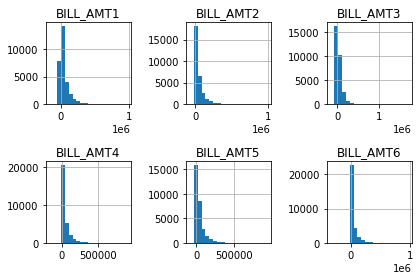

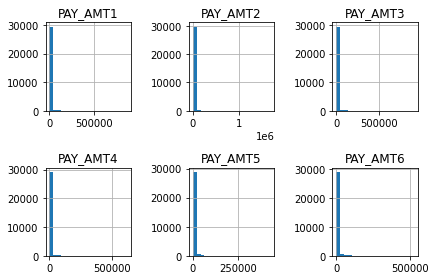

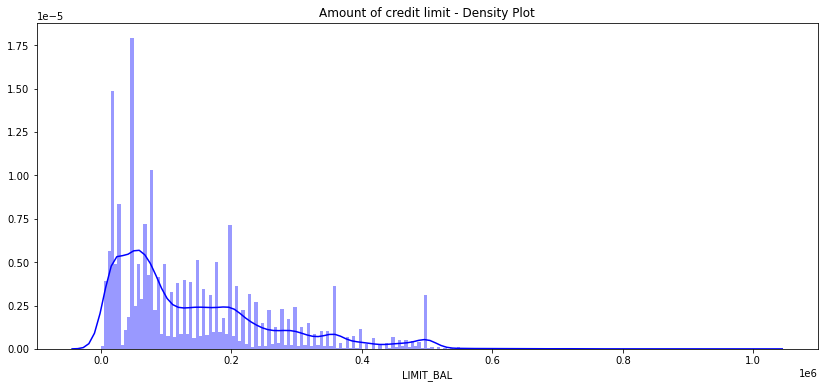

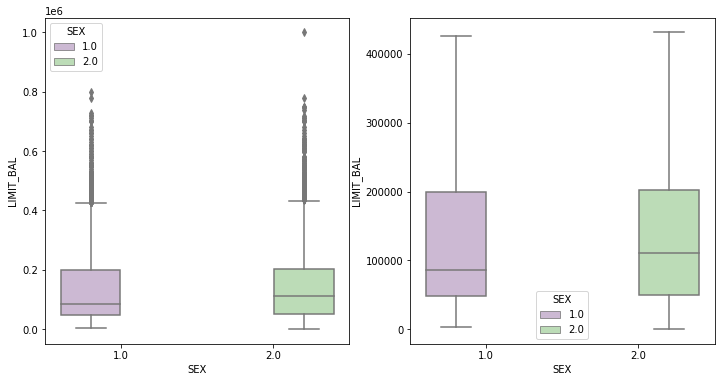

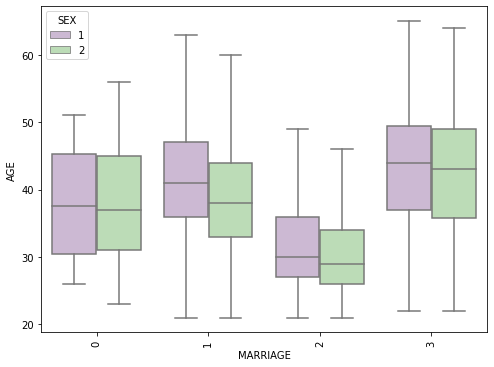

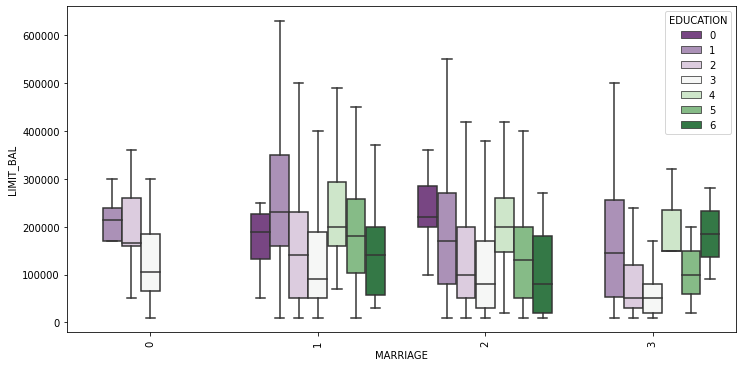

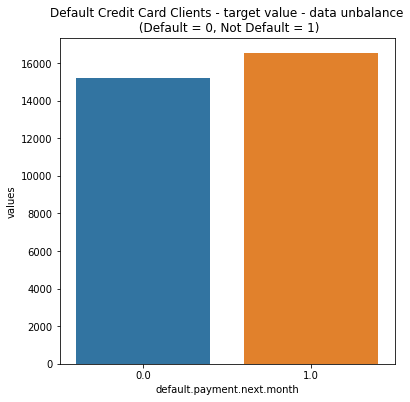

In [400]:
eda_analysis(ctgan_result_df)

In [390]:
samples = ctgan.sample(40000)
samples = samples[samples['default.payment.next.month'] ==1.0]
ctgan_result_df = pd.concat([ctgan_df,samples])
ctgan_result_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
29891,29892.0,100000.0,1.0,3.0,2.0,47.0,0.0,0.0,0.0,0.0,0.0,-2.0,94667.0,97088.0,99520.0,102650.0,0.0,0.0,4000.0,4000.0,5000.0,0.0,0.0,0.0,0.0
11659,11660.0,150000.0,2.0,3.0,1.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,59885.0,59054.0,60254.0,59604.0,60707.0,61988.0,2200.0,2200.0,2300.0,2213.0,2300.0,2245.0,0.0
747,748.0,300000.0,2.0,3.0,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,280823.0,275303.0,271952.0,193403.0,187562.0,191069.0,11000.0,12000.0,7200.0,6500.0,6173.0,5500.0,1.0
8312,8313.0,240000.0,1.0,2.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,227675.0,181461.0,186160.0,191355.0,192406.0,190086.0,10003.0,10009.0,10014.0,8500.0,10000.0,8000.0,0.0
25020,25021.0,160000.0,1.0,3.0,1.0,61.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,780.0,0.0,390.0,390.0,0.0


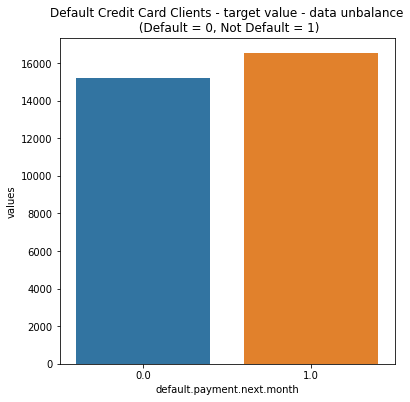

In [391]:
draw_imbalance(ctgan_result_df)

[0]	train-auc:0.81318	valid-auc:0.70186
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.91530	valid-auc:0.74107
[100]	train-auc:0.92362	valid-auc:0.75363
[150]	train-auc:0.92905	valid-auc:0.75500
[200]	train-auc:0.93285	valid-auc:0.76095
[250]	train-auc:0.93550	valid-auc:0.76573
[300]	train-auc:0.93773	valid-auc:0.76970
[350]	train-auc:0.93925	valid-auc:0.77272
[400]	train-auc:0.94025	valid-auc:0.77494
[450]	train-auc:0.94113	valid-auc:0.77675
[500]	train-auc:0.94183	valid-auc:0.77865
[550]	train-auc:0.94249	valid-auc:0.78027
[600]	train-auc:0.94316	valid-auc:0.78196
[650]	train-auc:0.94368	valid-auc:0.78316
[700]	train-auc:0.94421	valid-auc:0.78413
[750]	train-auc:0.94466	valid-auc:0.78511
[800]	train-auc:0.94510	valid-auc:0.78562
[850]	train-auc:0.94540	valid-auc:0.78601
[900]	train-auc:0.94567	valid-auc:0.78623
[950]	train-auc:0.94610	valid-auc:0.78681
[999]	train-auc:0.94

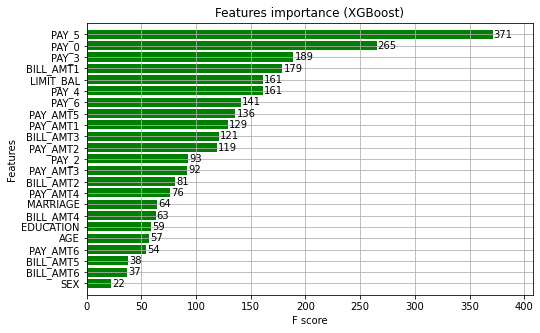

In [392]:
model = create_xgb_model(ctgan_result_df, val_df, predictors, target)

In [398]:
new_ctgan_df = pd.concat([ctgan_result_df,train_df])

[0]	train-auc:0.79354	valid-auc:0.70090
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.87719	valid-auc:0.74798
[100]	train-auc:0.88671	valid-auc:0.76153
[150]	train-auc:0.89380	valid-auc:0.76594
[200]	train-auc:0.89836	valid-auc:0.77058
[250]	train-auc:0.90173	valid-auc:0.77386
[300]	train-auc:0.90384	valid-auc:0.77612
[350]	train-auc:0.90542	valid-auc:0.77760
[400]	train-auc:0.90676	valid-auc:0.77894
[450]	train-auc:0.90791	valid-auc:0.78016
[500]	train-auc:0.90897	valid-auc:0.78140
[550]	train-auc:0.90995	valid-auc:0.78252
[600]	train-auc:0.91090	valid-auc:0.78371
[650]	train-auc:0.91155	valid-auc:0.78428
[700]	train-auc:0.91226	valid-auc:0.78488
[750]	train-auc:0.91296	valid-auc:0.78516
[800]	train-auc:0.91343	valid-auc:0.78546
[850]	train-auc:0.91398	valid-auc:0.78572
[900]	train-auc:0.91459	valid-auc:0.78609
[950]	train-auc:0.91528	valid-auc:0.78641
[999]	train-auc:0.91

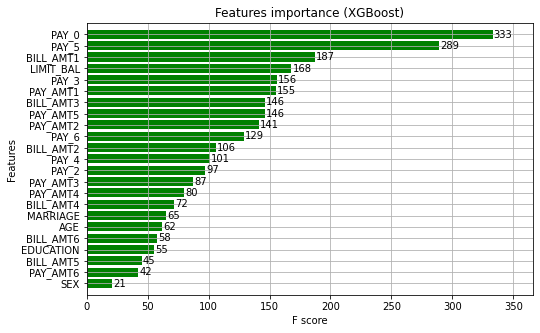

In [399]:
model = create_xgb_model(new_ctgan_df, val_df, predictors, target)

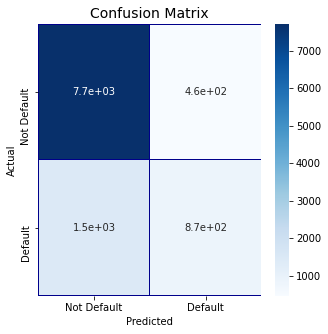

0.6586496005974638


In [310]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifie

def create_randomforest_model(train_df, val_df, predictors, target):
    clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)
    
    clf.fit(train_df[predictors], train_df[target].values)


    
    preds = clf.predict(val_df[predictors])
    
    cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Default', 'Default'],
                yticklabels=['Not Default', 'Default'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    
    print(roc_auc_score(val_df[target].values, preds))



create_randomforest_model(train_df, val_df, predictors, target)

#create_randomforest_model(train_SMOTE, val_df, predictors, target)

# create_randomforest_model(ctgan_result_df, val_df, predictors, target)


# <a id="7">Conclusions</a>

# <a id="8">References</a>

[1] Default Credit Card Clients Dataset,  https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/  
[2] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[3] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[5] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html   
[6] CatBoostClassifier, https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
[7] XGBoost Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
[8] LightGBM Python implementation, https://github.com/Microsoft/LightGBM/tree/master/python-package  
[9] LightGBM algorithm, https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf   

